<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Automatically created module for IPython interactive environment
________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.868443
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.993919

time elapsed: 4.10s


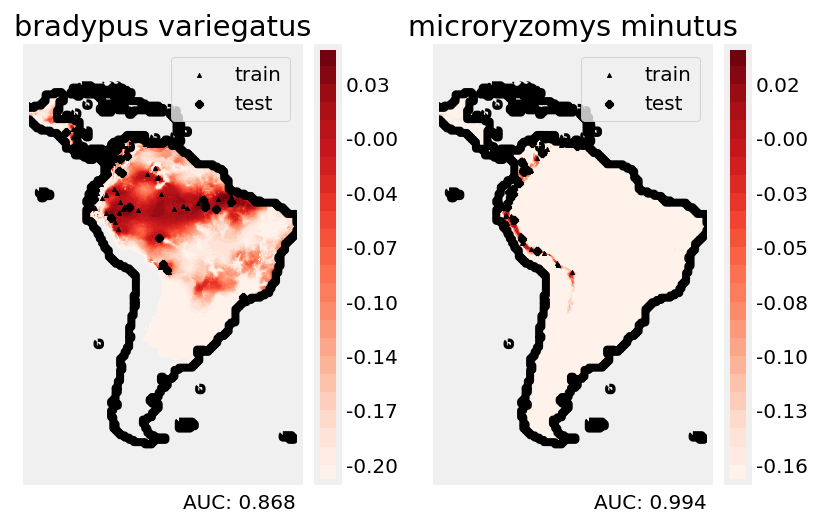

In [1]:
# Authors: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#          Jake Vanderplas <vanderplas@astro.washington.edu>
#
# License: BSD 3 clause

from __future__ import print_function

from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets.base import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn import svm, metrics

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

print(__doc__)


def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=' '.join(species_name.split("_")[:2]))
    species_name = species_name.encode('ascii')
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts['species'] == species_name]
        bunch['pts_%s' % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts['dd long'])
        iy = np.searchsorted(ygrid, pts['dd lat'])
        bunch['cov_%s' % label] = coverages[:, -iy, ix].T

    return bunch


def plot_species_distribution(species=("bradypus_variegatus_0",
                                       "microryzomys_minutus_0")):
    """
    Plot the species distribution.
    """
    if len(species) > 2:
        print("Note: when more than two species are provided,"
              " only the first two will be used")

    t0 = time()

    # Load the compressed data
    data = fetch_species_distributions()

    # Set up the data grid
    xgrid, ygrid = construct_grids(data)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    # create a bunch for each species
    BV_bunch = create_species_bunch(species[0],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)
    MM_bunch = create_species_bunch(species[1],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)

    # background points (grid coordinates) for evaluation
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=data.Ny,
                                                size=10000),
                              np.random.randint(low=0, high=data.Nx,
                                                size=10000)].T

    # We'll make use of the fact that coverages[6] has measurements at all
    # land points.  This will help us decide between land and water.
    land_reference = data.coverages[6]

    # Fit, predict, and plot for each species.
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # Standardize features
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassSVM ... ", end='')
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        # Plot map of South America
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                        urcrnrlat=Y.max(), llcrnrlon=X.min(),
                        urcrnrlon=X.max(), resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(X, Y, land_reference,
                        levels=[-9998], colors="k",
                        linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # Predict species distribution using the training data
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # We'll predict only for the land points.
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # plot contours of the prediction
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format='%.2f')

        # scatter training/testing points
        plt.scatter(species.pts_train['dd long'], species.pts_train['dd lat'],
                    s=2 ** 2, c='black',
                    marker='^', label='train')
        plt.scatter(species.pts_test['dd long'], species.pts_test['dd lat'],
                    s=2 ** 2, c='black',
                    marker='x', label='test')
        plt.legend()
        plt.title(species.name)
        plt.axis('equal')

        # Compute AUC with regards to background points
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean) / std)
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))


plot_species_distribution()
plt.show()

NameError: name 'NaturalEarthFeature' is not defined

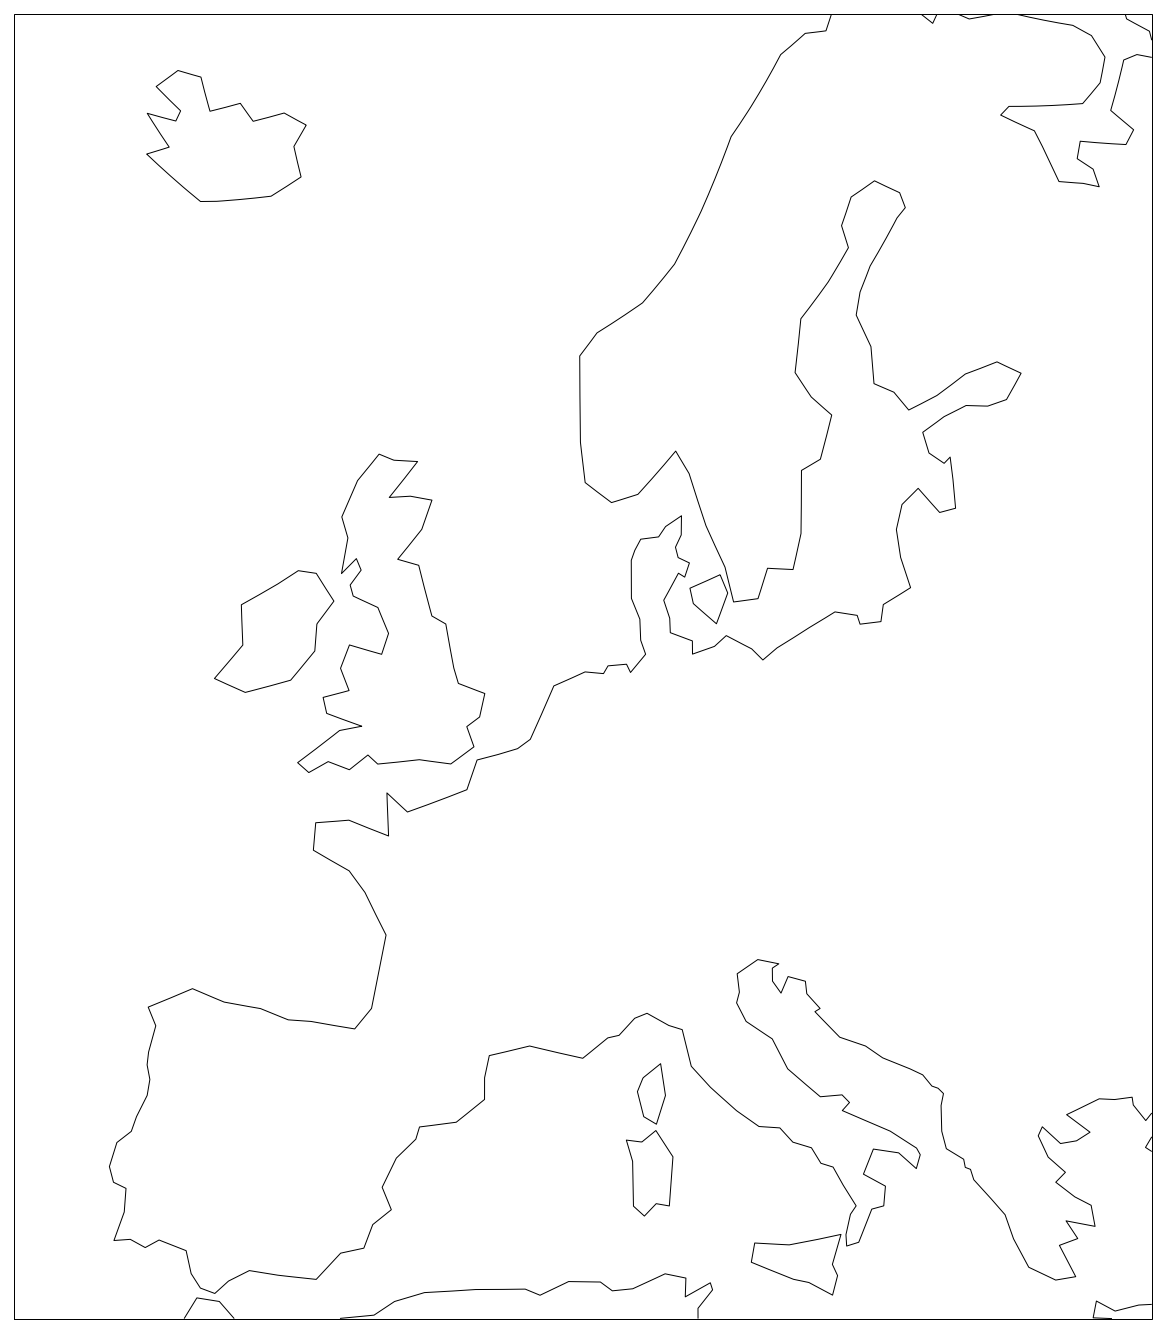

<Figure size 1440x864 with 0 Axes>

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


def main():
    fig = plt.figure(figsize=[20,12])
    plt.figure(figsize=[20,12])
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.EuroPP())
    ax.set_extent([-1400000.0, 2000000.0,4000000.0, 7900000.0],crs=ccrs.EuroPP())

#     ax.add_feature(cfeature.LAND)
#     ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(NaturalEarthFeature('physical','admin_0_boundary_lines_land'))
#     ax.add_feature(cfeature.BORDERS, linestyle=':')
#     ax.add_feature(cfeature.LAKES, alpha=0.5)
#     ax.add_feature(cfeature.RIVERS)
#     ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.gridlines()
    ax.natural_earth_shp()
    ax.coastlines(resolution='110m', color='black', linewidth=1)
    ax.stock_img()
#     ax.set_xlim([10,10])
#     ax.set_ylim([10,10])
    plt.show()


if __name__ == '__main__':
    main()

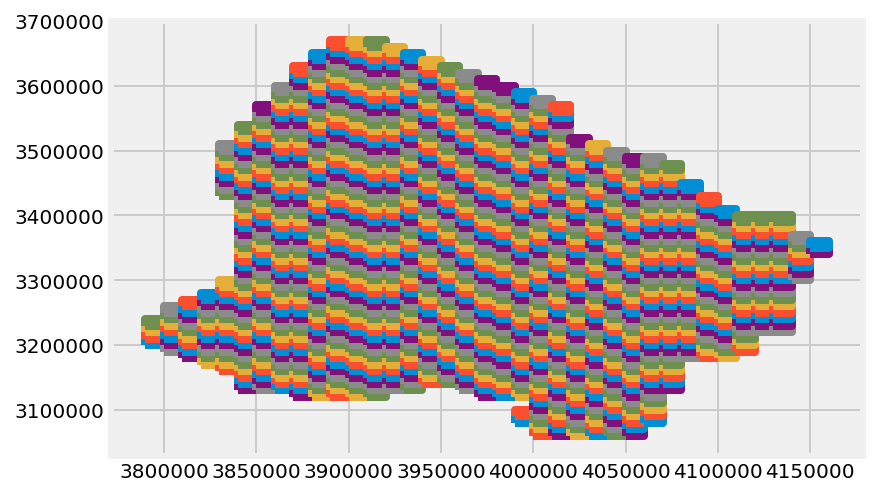

In [12]:
# https://gis.stackexchange.com/questions/131716/plot-shapefile-with-matplotlib

import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt

sf = shp.Reader("/Users/maartenk/Documents/git/Cookbooks/Sources/nl_10km.shp")

plt.figure()
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

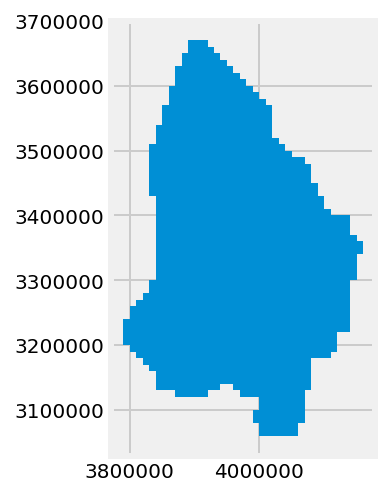

In [119]:
fp = "/Users/maartenk/Documents/git/Cookbooks/Sources/nl_10km.shp"
map_df = gpd.read_file(fp)
map_df.plot()

In [120]:
shape_ex = sf.shape(5)

In [121]:
x_lon = np.zeros((len(shape_ex.points),1))

In [122]:
y_lat = np.zeros((len(shape_ex.points),1))
for ip in range(len(shape_ex.points)):
    x_lon[ip] = shape_ex.points[ip][0]
    y_lat[ip] = shape_ex.points[ip][1]
# plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])

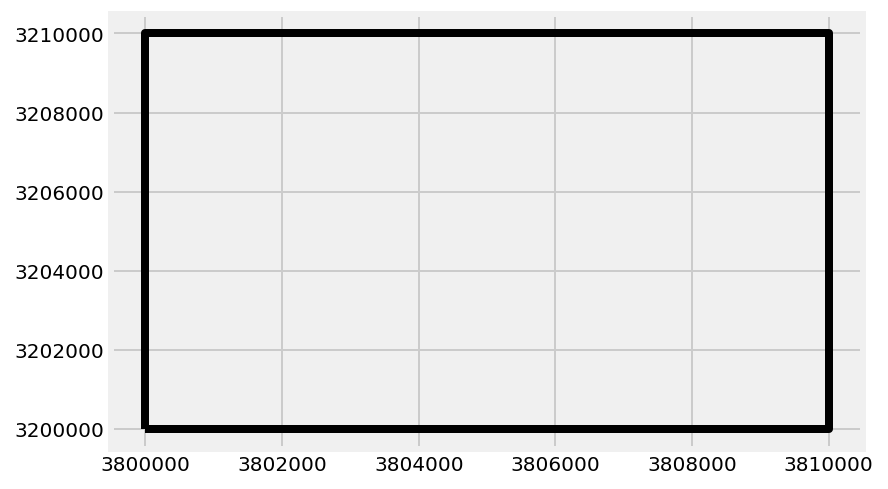

In [123]:
plt.plot(x_lon,y_lat,'k')

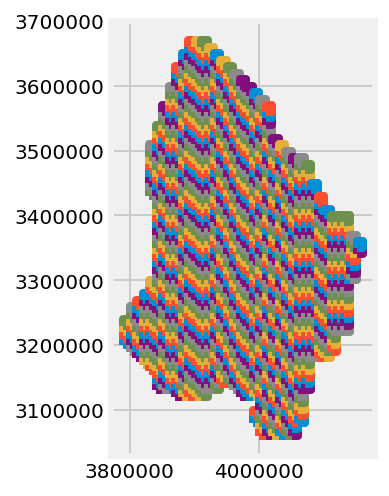

In [124]:
plt.figure()
ax = plt.axes()
ax.set_aspect('equal')
for shape in list(sf.iterShapes()):
   x_lon = np.zeros((len(shape.points),1))
   y_lat = np.zeros((len(shape.points),1))
   for ip in range(len(shape.points)):
       x_lon[ip] = shape.points[ip][0]
       y_lat[ip] = shape.points[ip][1]

   plt.plot(x_lon,y_lat)


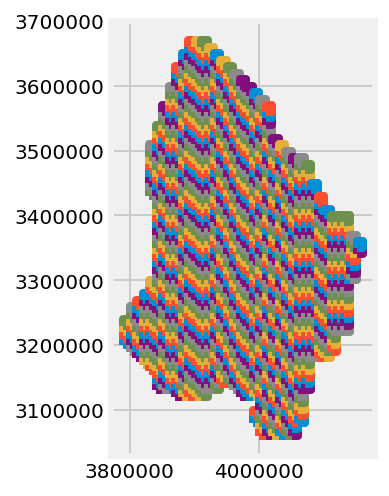

In [125]:
plt.figure()
ax = plt.axes() # add the axes
ax.set_aspect('equal')

for shape in list(sf.iterShapes()):
    npoints=len(shape.points) # total points
    nparts = len(shape.parts) # total parts

    if nparts == 1:
       x_lon = np.zeros((len(shape.points),1))
       y_lat = np.zeros((len(shape.points),1))
       for ip in range(len(shape.points)):
           x_lon[ip] = shape.points[ip][0]
           y_lat[ip] = shape.points[ip][1]
       plt.plot(x_lon,y_lat)

    else: # loop over parts of each shape, plot separately
        for ip in range(nparts): # loop over parts, plot separately
            i0=shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = npoints
                
            seg=shape.points[i0:i1+1]
            x_lon = np.zeros((len(seg),1))
            y_lat = np.zeros((len(seg),1))
            for ip in range(len(seg)):
                x_lon[ip] = seg[ip][0]
                y_lat[ip] = seg[ip][1]

            plt.plot(x_lon,y_lat)

# plt.xlim(-130,-60)
# plt.ylim(23,50)
plt.show()

In [41]:
# load libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [45]:
shapedir='/Users/maartenk/Documents/git/Cookbooks/Sources/ShapeFiles/'

In [56]:
file = 'BAG-Woonplaatsgrenzen.shp' 
# fp = f'{shapedir}BAG-Woonplaatsgrenzen.shp'
fp = shapedir+file
# fp = "/Users/maartenk/Documents/git/Cookbooks/Sources/nl_10km.shp"
fp_ = shapedir+'nl_imergis_kustlijn_2018.shp'
fp__ = shapedir+'ESRI-PC4-2017R1.shp'

map_df = gpd.read_file(fp)
map_df_ = gpd.read_file(fp_)
map_df__ = gpd.read_file(fp__)

In [59]:
WoonKernen = shapedir+'Top10NL-Plaats_kern.shp'
map_df_WoonKernen = gpd.read_file(WoonKernen)

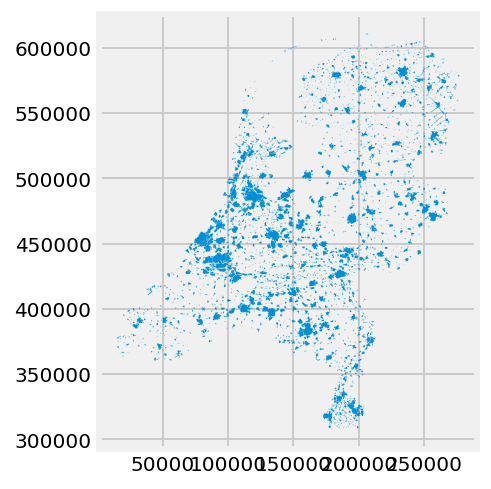

In [62]:
map_df_WoonKernen.plot()

In [14]:
map_df_cbs.shape

(4066, 36)

In [30]:
map_df.head()

id identifica gemcode      gemnaam                 status         naam  \
0   0       1000    0873  Woensdrecht  Woonplaats aangewezen  Hoogerheide   
1   1       1001    0873  Woensdrecht  Woonplaats aangewezen   Huijbergen   
2  15       1014    0342        Soest  Woonplaats aangewezen  Soesterberg   
3  16       1015    0622  Vlaardingen  Woonplaats aangewezen  Vlaardingen   
4   2       1002    0873  Woensdrecht  Woonplaats aangewezen  Ossendrecht   

   begindatum einddatumt inonderzoe            documentnu  documentda  \
0  2010-04-06       None          N  2010WP00000000000569  2010-04-06   
1  2010-04-06       None          N  2010WP00000000000569  2010-04-06   
2  2007-01-16       None          N           AZ/2007/224  2007-01-16   
3  2007-01-30       None          N         VLD/2007/5652  2007-01-30   
4  2010-04-06       None          N  2010WP00000000000569  2010-04-06   

  indicatie_ aanduiding  aanduidi_1                        key  mutatiedat  \
0          N          N           0  1000_2010040600000200_N_0  2016-11-07   
1          N          N           0  1001_2010040600000200_N_0  2016-11-07   
2          N          N           0  1014_2007011600000000_N_0  2016-11-07   
3          N          N           0  1015_2007013000000000_N_0  2016-11-07   
4          N          N           0  1002_2010040600000200_N_0  2016-11-07   

                                            geometry  
0  POLYGON ((78988.952 384548.144, 78974.22100000...  
1  POLYGON ((85176.754 385052.744, 85088.95 38484...  
2  POLYGON ((148967.438 459736.006, 148958.809 45...  
3  POLYGON ((78139.54300000001 435983.394, 78146....  
4  POLYGON ((83128.02499999999 376777.244, 83047....

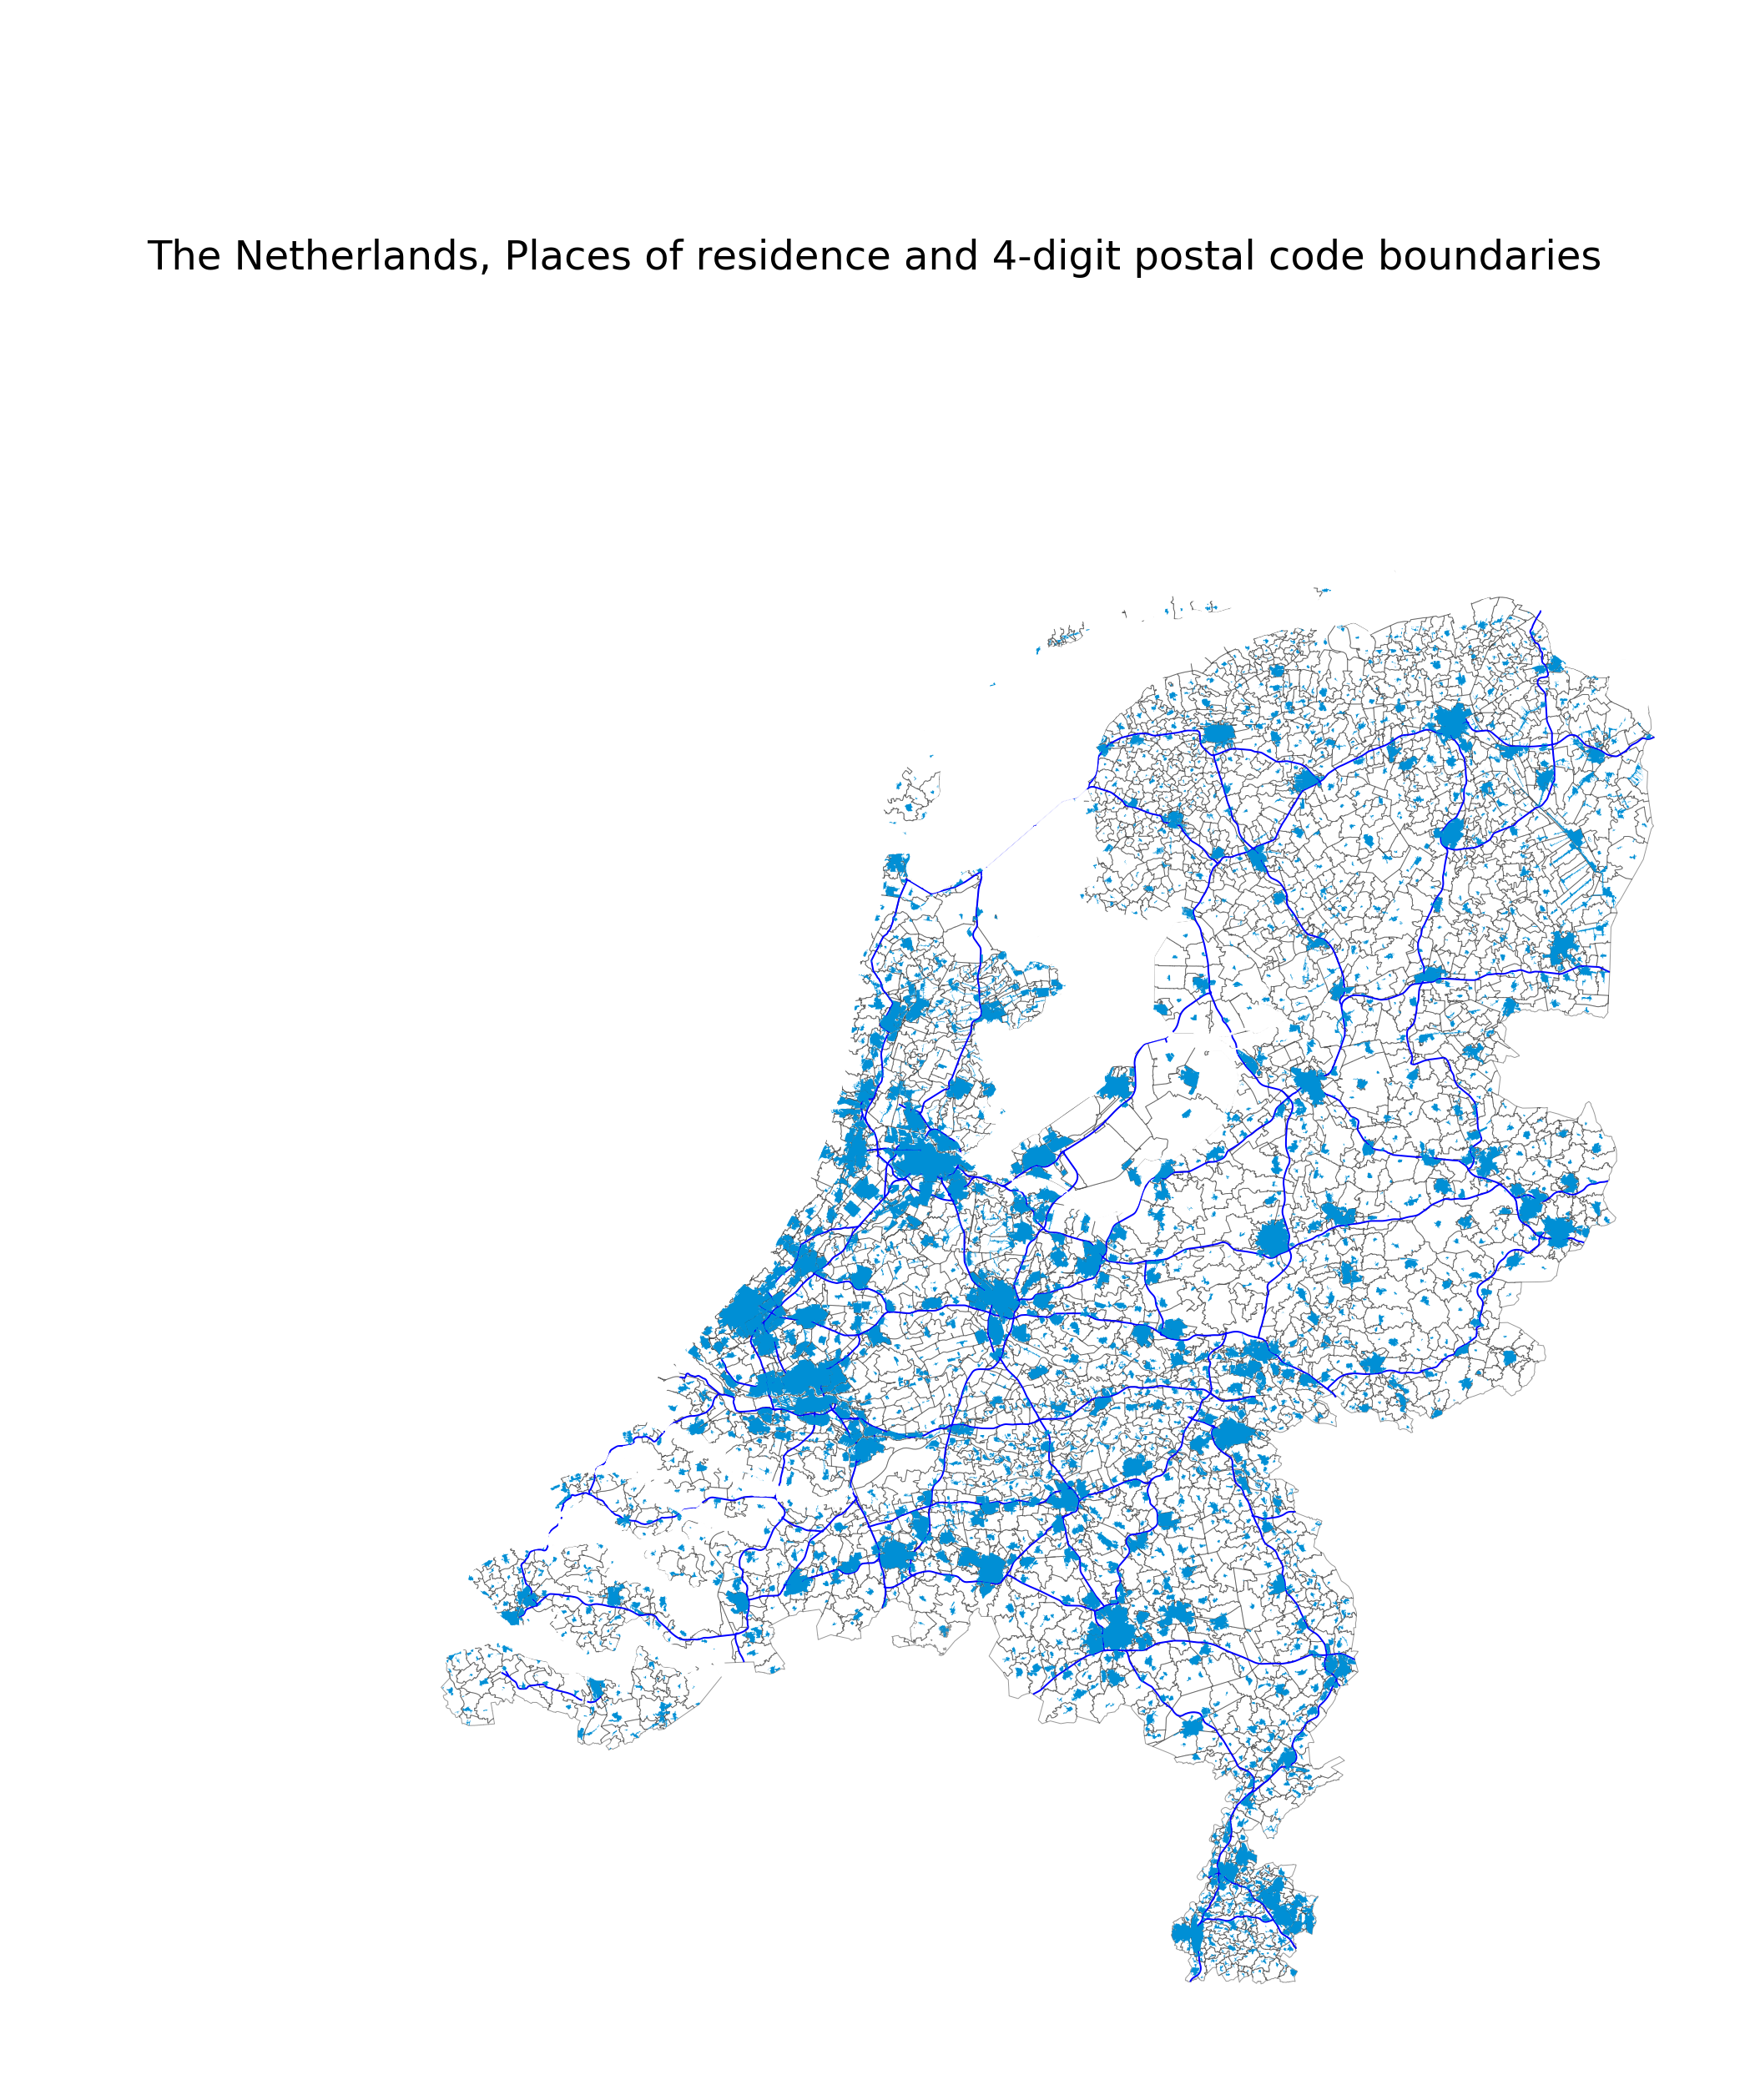

In [72]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes()
ax.set_aspect('equal')
ax.set_axis_off()
# ax.axis('equal')
# ax.axis('off')
# map_df.plot(cmap='inferno',ax=ax, linewidth=1, edgecolor="black")
map_df_.plot(edgecolor='white', facecolor='white',ax=ax, zorder=3)
map_df__.plot(ax=ax, alpha=.4, edgecolor='black', facecolor='white')
map_df_WoonKernen.plot(ax=ax,zorder=4)
map_df_roads.loc[map_df_roads['BEHEERDER']=='R'].plot(lw=1, color='blue', ax=ax)
fig.suptitle("\n\n\n\n\nThe Netherlands, Places of residence and 4-digit postal code boundaries", fontsize=24)
plt.show()

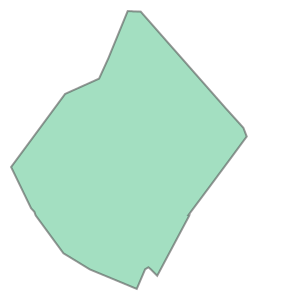

In [8]:
map_df.loc[5, 'geometry']

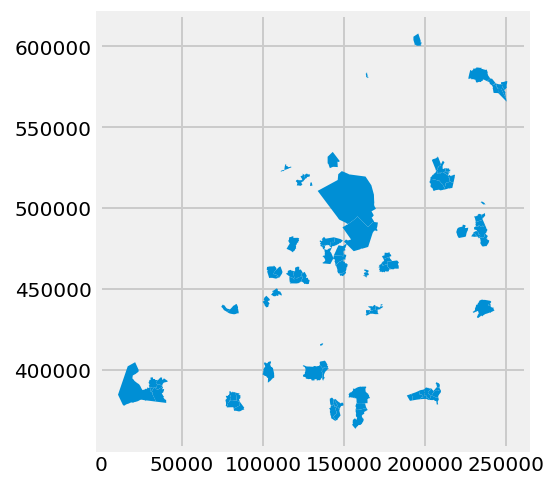

In [9]:
map_df.loc[0:100].plot();

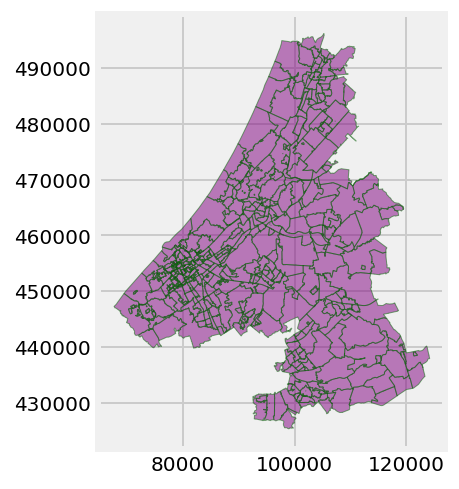

In [10]:
map_df__.loc[(map_df__['PC4'].astype(int) > 1999) & (map_df__['PC4'].astype(int) < 2999), ].plot(facecolor='purple', edgecolor='darkgreen', alpha=.5)

In [11]:
map_df__.dtypes

OBJECTID      float64
PC4            object
Aantal_mul      int64
Aantal_adr      int64
Shape_Leng    float64
Shape_Area    float64
geometry       object
dtype: object

In [70]:
roads = shapedir+'nwb-light.shp'

map_df_roads = gpd.read_file(roads)


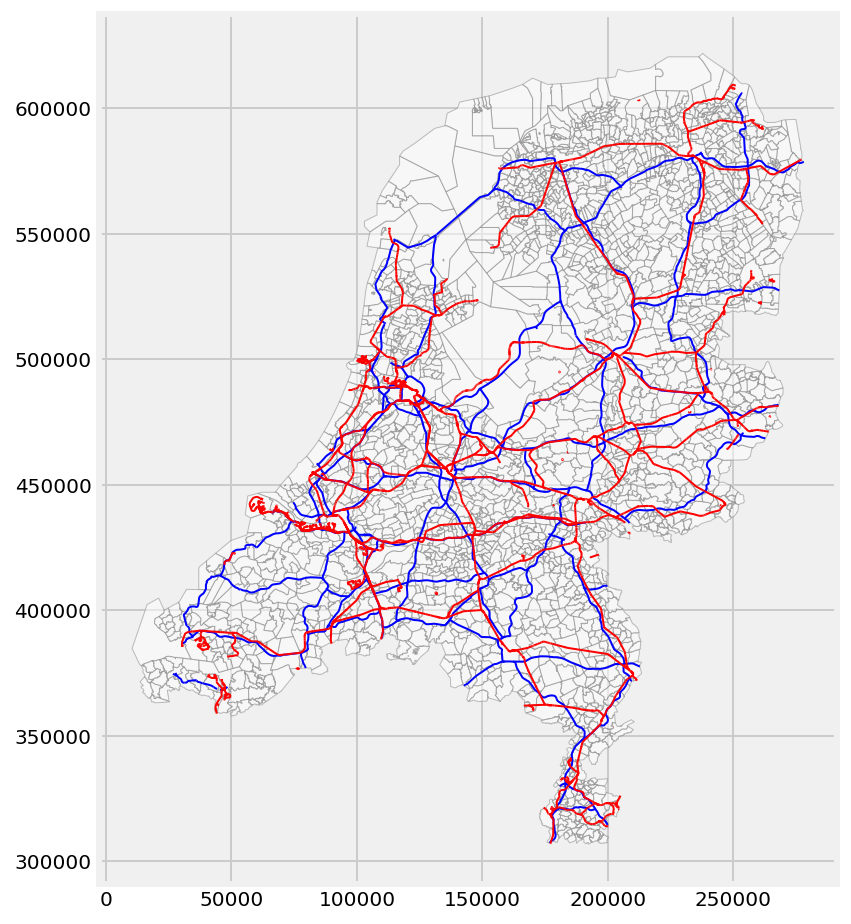

In [82]:
fig, ax = plt.subplots(1,figsize=(8,8))
map_df.plot(ax=ax, facecolor='white', edgecolor='grey', alpha=.5)
map_df_roads.loc[map_df_roads['BEHEERDER']=='R'].plot(lw=1, color='blue', ax=ax)
map_df_rail.loc[map_df_rail['typespoorb']=='trein'].plot(lw=1, color='r',ax=ax)

In [73]:
rail = shapedir+'Top10NL_Spoorwegen.shp'

map_df_rail = gpd.read_file(rail)




In [81]:
map_df_rail.head()

ogc_fid                gml_id   namespace   lokaalid   brontype  \
0        1  nl.top10nl.128308363  NL.TOP10NL  128308363  luchtfoto   
1        2  nl.top10nl.128308364  NL.TOP10NL  128308364  luchtfoto   
2        3  nl.top10nl.128524200  NL.TOP10NL  128524200  luchtfoto   
3        4  nl.top10nl.128524199  NL.TOP10NL  128524199  luchtfoto   
4        5  nl.top10nl.128835196  NL.TOP10NL  128835196  luchtfoto   

   bronactual                                         bronbeschr  bronnauwke  \
0  2015-01-01  Een orthogerectificeerde fotografische opname ...         0.1   
1  2015-01-01  Een orthogerectificeerde fotografische opname ...         0.1   
2  2014-01-01  Een orthogerectificeerde fotografische opname ...         0.1   
3  2014-01-01  Een orthogerectificeerde fotografische opname ...         0.1   
4  2015-01-01  Een orthogerectificeerde fotografische opname ...         0.1   

   objectbegi objecteind  tijdstipre eindregist  tdncode  visualisat  \
0  2015-01-24       None  2016-02-01       None    404.0       11400   
1  2015-01-24       None  2016-02-01       None    404.0       11400   
2  2015-03-28       None  2016-02-01       None    404.0       11400   
3  2015-03-28       None  2016-02-01       None    404.0       11400   
4  2015-08-30       None  2016-11-01       None    404.0       11400   

  mutatietyp typeinfras typespoorb fysiekvoor    spoorbreed aantalspor  \
0       None   kruising      trein       None  normaalspoor     dubbel   
1       None   kruising      trein       None  normaalspoor     dubbel   
2       None   kruising      trein       None  normaalspoor     dubbel   
3       None   kruising      trein       None  normaalspoor     dubbel   
4       None   kruising      trein       None  normaalspoor     dubbel   

        vervoerfun elektrific  hoogtenive      status brugnaam tunnelnaam  \
0  gemengd gebruik         ja           0  in gebruik     None       None   
1  gemengd gebruik         ja           0  in gebruik     None       None   
2  gemengd gebruik         ja           0  in gebruik     None       None   
3  gemengd gebruik         ja           0  in gebruik     None       None   
4  gemengd gebruik         ja           0  in gebruik     None       None   

  baanvaknaa                                         geometrie_ geometry  
0       None  SRID=28992;POINT(177277.607000001 318346.50800...     None  
1       None  SRID=28992;POINT(177499.335999999 317610.04899...     None  
2       None      SRID=28992;POINT(231449.203000002 541791.169)     None  
3       None  SRID=28992;POINT(231294.780000001 541036.38500...     None  
4       None  SRID=28992;POINT(140846.366999999 471167.79199...     None

In [14]:
map_df__.crs

{'init': 'epsg:28992'}

(3.112083774745878, 7.424212998209364, 50.60987252488362, 53.71889842617229)

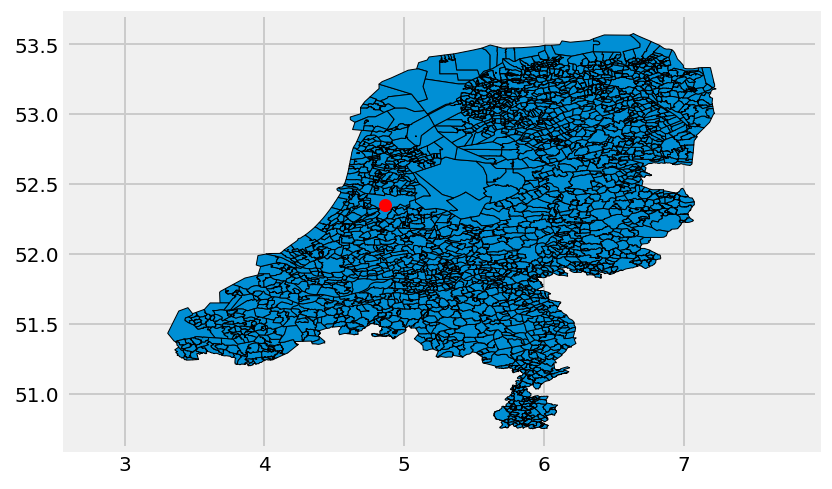

In [33]:
map_df.to_crs(epsg=4289).plot(edgecolor='black')

# map_df.to_crs(crs = 28992, epsg=4833).plot(figsize=(20,12), edgecolor='black')
lon=52.3545653,
lon=52.3545653,
lat=4.8585408
plt.scatter(lat,lon, c='r')
plt.axis('equal')

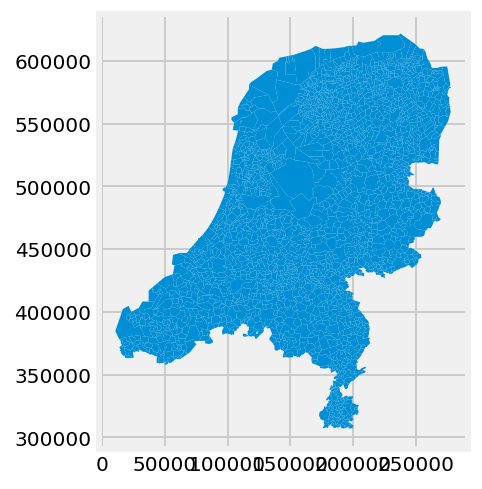

In [221]:
lat=52.3545653,
lon=4.7585408
lims=map_df.to_crs(epsg=28992).plot()
# plt.axis('equal')

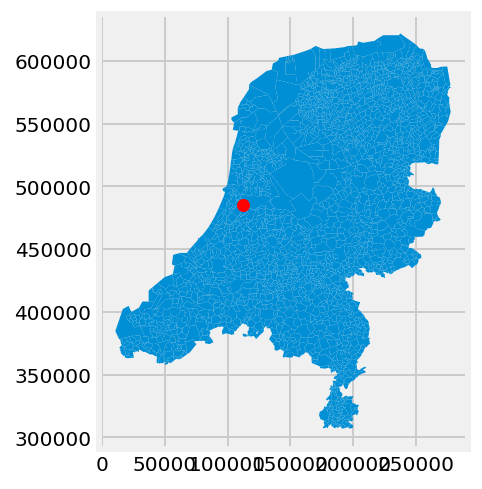

In [219]:
map_df.plot()
plt.scatter(112170, 485370, color='red')

In [3]:
cbs = '/Users/maartenk/Documents/git/Cookbooks/Sources/CBS_PC4_2017_v1.shp'

map_df_cbs = gpd.read_file(cbs)



No handles with labels found to put in legend.


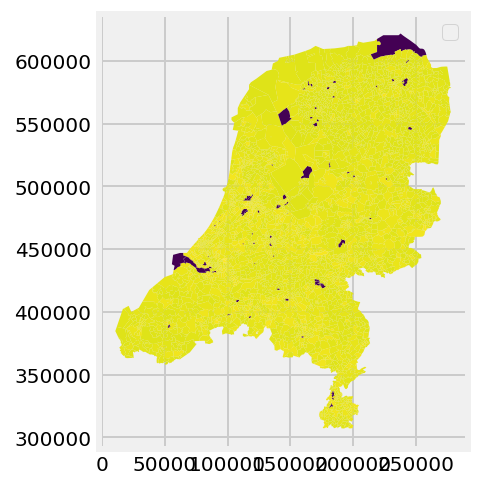

In [36]:
map_df_cbs.plot(column='INW_65PL')
plt.legend()

In [5]:
map_df_cbs.head(10)

PC4  INWONER    MAN  VROUW  INW_014  INW_1524  INW_2544  INW_4564  \
0  1011     9645   4990   4655      800      1195      3195      2920   
1  1012     8240   4480   3760      465      1195      4195      1730   
2  1013    21080  10550  10525     2640      1860      7685      6115   
3  1014      645    375    270       65        45       400       115   
4  1015    14810   7545   7265     1410      1465      5235      4365   
5  1016    10875   5595   5280      920      1110      4115      3000   
6  1017    12665   6690   5975     1230      1565      5040      3145   
7  1018    20825  10725  10100     2160      2655      7135      6050   
8  1019    18705   9420   9285     3115      1825      5775      6480   
9  1021     7030   3565   3465     1110       830      2445      1870   

   INW_65PL  GEBOORTE  P_AUTOCHT  P_WALLOCH  P_NWALLOCH  AANTAL_HH  \
0      1540        75         60         30          10       6380   
1       650        50         50         30          10       5960   
2      2775       280         60         20          20      12580   
3        20        15         60         20          20        330   
4      2340       125         60         30          10       9740   
5      1725       125         60         30          10       7320   
6      1685       115         60         30          10       8170   
7      2820       195         60         20          20      12665   
8      1510       215         60         20          20       9325   
9       775        85         40         10          50       3790   

   TOTHH_EENP  TOTHH_MPZK  HH_EENOUD  HH_TWEEOUD  GEM_HH_GR  WONING  \
0        4175        1305        345         500        1.5    6110   
1        4245        1175        190         260        1.4    5695   
2        7525        2430       1020        1510        1.7   12825   
3         170         105         10          45        1.7     270   
4        6340        1925        535         860        1.5    9865   
5        4940        1415        325         575        1.5    7510   
6        5250        1690        325         795        1.5    7960   
7        7955        2445        790        1365        1.6   11325   
8        4055        2300        915        1995        2.0    8760   
9        2070         675        450         550        1.8    3485   

   WONVOOR45  WON_4564  WON_6574  WON_7584  WON_8594  WON_9504  WON_0514  \
0       3605       115       115       800       390       670       370   
1       4725        20        50        85       490       225       105   
2       6930        75       115      1625      1475       445      2005   
3         20         5         5         5        20       185    -99997   
4       7275       100       235       755      1075       340        80   
5       5695        50        35       385       890       185       120   
6       6345       160       105       345       455       395       150   
7       5190       150       200      1385      2870       980       415   
8        805        20    -99997    -99997      2080      4890       800   
9       1645        55    -99997      1010       645    -99997       130   

   WON_1524  WON_MRGEZ  G_GAS_WON  G_ELEK_WON  UITKMINAOW    OAD  STED  \
0        45       5915        900        2060         825   6907     1   
1    -99997       5380       1090        2150         480   8410     1   
2       160      12670        920        1990        2720   6224     1   
3        25        225       1000        2160          80   2645     1   
4    -99997       9385       1050        1960        1395  10975     1   
5       160       7150       1100        2090         800  11230     1   
6    -99997       7170       1200        2350         615   9277     1   
7       135      11130        930        2070        2555   6807     1   
8       160       8025        420        2500        1615   4231     1   
9    -99997       3400        990        1950        1310   2720     1

In [47]:
map_df_cbs.loc[map_df_cbs['INWONER'].astype(int)> 20000].count()#.plot()

PC4           13
INWONER       13
MAN           13
VROUW         13
INW_014       13
INW_1524      13
INW_2544      13
INW_4564      13
INW_65PL      13
GEBOORTE      13
P_AUTOCHT     13
P_WALLOCH     13
P_NWALLOCH    13
AANTAL_HH     13
TOTHH_EENP    13
TOTHH_MPZK    13
HH_EENOUD     13
HH_TWEEOUD    13
GEM_HH_GR     13
WONING        13
WONVOOR45     13
WON_4564      13
WON_6574      13
WON_7584      13
WON_8594      13
WON_9504      13
WON_0514      13
WON_1524      13
WON_MRGEZ     13
G_GAS_WON     13
G_ELEK_WON    13
UITKMINAOW    13
OAD           13
STED          13
geometry      13
dtype: int64

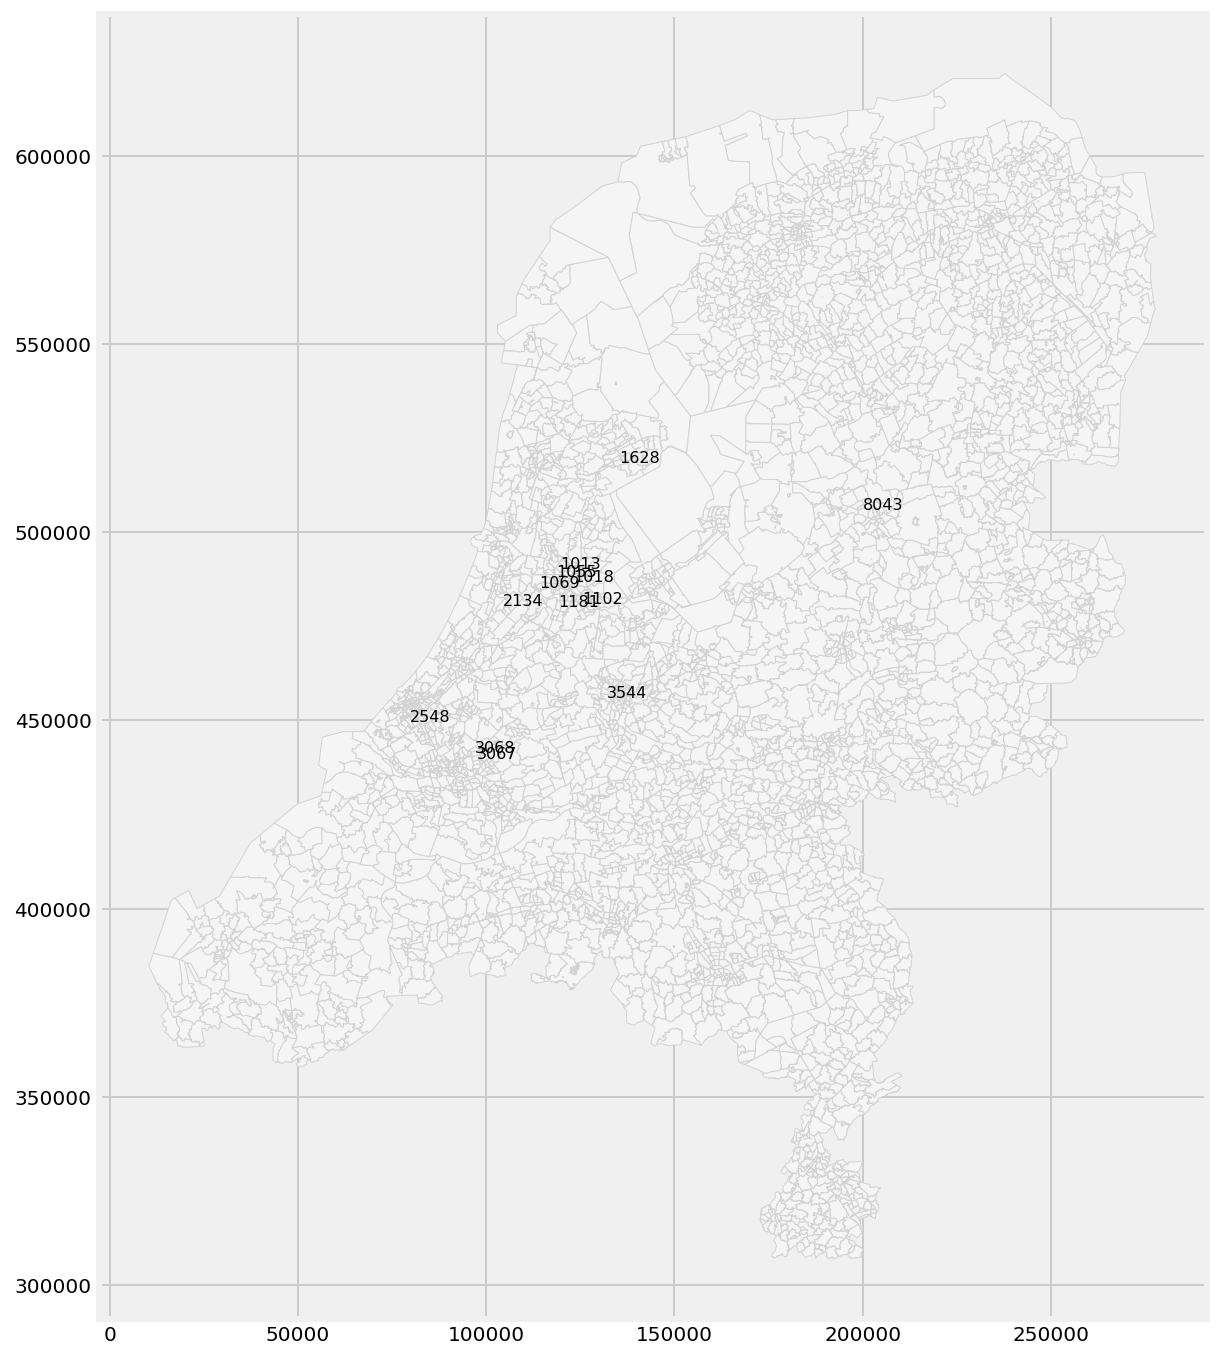

In [4]:

import adjustText as aT

map_df_cbs['rep']= map_df_cbs['geometry'].representative_point()
map_df_cbs_points = map_df_cbs.loc[map_df_cbs['INWONER'].astype(int)> 20000].copy()
map_df_cbs_points.set_geometry('rep', inplace = True)

ax = map_df_cbs.plot(figsize = (15, 12), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
texts = []

for x, y, label in zip(map_df_cbs_points.geometry.x, map_df_cbs_points.geometry.y, map_df_cbs_points['PC4']):
    texts.append(plt.text(x, y, label, fontsize = 8))

# aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
#                arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

In [51]:
!pip install adjustText

  Running setup.py bdist_wheel for adjustText ... done
  Stored in directory: /Users/maartenk/Library/Caches/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [23]:
map_df_combined = pd.merge(map_df__, map_df_cbs, left_on=map_df__['PC4'], right_on=map_df_cbs['PC4'].astype(str))

In [24]:
map_df_combined.head()

key_0  OBJECTID PC4_x  Aantal_mul  Aantal_adr    Shape_Leng    Shape_Area  \
0  1011       1.0  1011           1        7466   5908.190943  1.034025e+06   
1  1012       2.0  1012           1        9261   5489.203939  1.214502e+06   
2  1013       3.0  1013           2       15159  19421.006995  5.075544e+06   
3  1014       4.0  1014           4        1640  15355.645043  2.674418e+06   
4  1015       5.0  1015           1       11274   4732.836386  7.704063e+05   

                                          geometry_x  PC4_y  INWONER    MAN  \
0  POLYGON ((122246.2320000008 487910.1770000011,...   1011     9645   4990   
1  POLYGON ((121995.0291999988 488243.2021000013,...   1012     8240   4480   
2  (POLYGON ((120506.2192000002 489494.5513000004...   1013    21080  10550   
3  (POLYGON ((120390.1125999987 489860.7457000017...   1014      645    375   
4  POLYGON ((120665.6422999986 488535.5, 120668.7...   1015    14810   7545   

   VROUW  INW_014  INW_1524  INW_2544  INW_4564  INW_65PL  GEBOORTE  \
0   4655      800      1195      3195      2920      1540        75   
1   3760      465      1195      4195      1730       650        50   
2  10525     2640      1860      7685      6115      2775       280   
3    270       65        45       400       115        20        15   
4   7265     1410      1465      5235      4365      2340       125   

   P_AUTOCHT  P_WALLOCH  P_NWALLOCH  AANTAL_HH  TOTHH_EENP  TOTHH_MPZK  \
0         60         30          10       6380        4175        1305   
1         50         30          10       5960        4245        1175   
2         60         20          20      12580        7525        2430   
3         60         20          20        330         170         105   
4         60         30          10       9740        6340        1925   

   HH_EENOUD  HH_TWEEOUD  GEM_HH_GR  WONING  WONVOOR45  WON_4564  WON_6574  \
0        345         500        1.5    6110       3605       115       115   
1        190         260        1.4    5695       4725        20        50   
2       1020        1510        1.7   12825       6930        75       115   
3         10          45        1.7     270         20         5         5   
4        535         860        1.5    9865       7275       100       235   

   WON_7584  WON_8594  WON_9504  WON_0514  WON_1524  WON_MRGEZ  G_GAS_WON  \
0       800       390       670       370        45       5915        900   
1        85       490       225       105    -99997       5380       1090   
2      1625      1475       445      2005       160      12670        920   
3         5        20       185    -99997        25        225       1000   
4       755      1075       340        80    -99997       9385       1050   

   G_ELEK_WON  UITKMINAOW    OAD  STED  \
0        2060         825   6907     1   
1        2150         480   8410     1   
2        1990        2720   6224     1   
3        2160          80   2645     1   
4        1960        1395  10975     1   

                                          geometry_y  \
0  POLYGON ((122246.2320000008 487910.1770000011,...   
1  POLYGON ((121995.0291999988 488243.2021000013,...   
2  (POLYGON ((120506.2192000002 489494.5513000004...   
3  (POLYGON ((120390.1125999987 489860.7457000017...   
4  POLYGON ((120665.6422999986 488535.5, 120668.7...   

                                           rep  
0  POINT (122264.3922433806 487210.6475000009)  
1  POINT (121498.3445058847 487539.4634500016)  
2  POINT (119675.5228124818 490424.2598999999)  
3   POINT (118724.772818551 489551.0559999999)  
4  POINT (120755.4234844103 488069.7747499999)

In [34]:
gemeenten = '/Users/maartenk/Documents/git/Cookbooks/Sources/2019_gemeentegrenzen_kustlijn.gpkg'





map_df_gemeenten = gpd.read_file(gemeenten)


In [39]:
map_df_gemeenten.head()

id  gid  code   gemeentenaam  \
0   2   14  1719      Drimmelen   
1   3   15  0614     Westvoorne   
2   4   16  0279   Scherpenzeel   
3   5   17  1729  Gulpen-Wittem   
4   6   18  0160     Hardenberg   

                                            geometry  
0  (POLYGON ((107416.617 415030.81, 107671.011 41...  
1  (POLYGON ((62182.934 438381.125, 62209.308 438...  
2  (POLYGON ((161629.436 456087.238, 161634.058 4...  
3  (POLYGON ((188277.343 315958.217, 188275.109 3...  
4  (POLYGON ((235753.945 520891.056, 235788.817 5...